# Week 5 Exercises: COMPAS

Today, we'll be exploring deep neural networks and applying them to data related to the COMPAS algorithm. I got this data [here](https://github.com/propublica/compas-analysis), in case you're interested in exploring it on your own!

## Setting up the Environment

Run any code below by highlighting it and hitting `Shift + Enter`. Import the libraries below.

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras import backend as K
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import requests
import zipfile
import io

# Fix random seed for reproducibility.
np.random.seed(1337)

Using TensorFlow backend.


## Read in Data

Run the below code to load the data and select the columns we care about.

In [0]:
# Download and extract data.
r = requests.get("http://web.stanford.edu/class/cs21si/resources/unit3_resources.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

data = pd.read_csv("unit3_resources/compas-scores.csv", header = 0)

# Select fields we want.
fields_of_interest = ['name', 'sex', 'age', 'race', 'priors_count', 'c_charge_desc', 
                      'v_decile_score', 'decile_score', 'is_violent_recid', 'is_recid']
data = data[fields_of_interest]

# More interpretable column names.
data.columns = ['name', 'sex', 'age', 'race', 'num_priors', 'charge', 
                'violence_score', 'recidivism_score', 'violence_true', 'recidivism_true']

# Remove records with missing scores.
data = data.loc[(data.violence_score != -1) & (data.recidivism_score != -1)]
data = data.loc[(data.violence_true != -1) & (data.recidivism_true != -1)]
data.head()

,name,sex,age,race,num_priors,charge,violence_score,recidivism_score,violence_true,recidivism_true
0,miguel hernandez,Male,69,Other,0,Aggravated Assault w/Firearm,1,1,0,0
2,kevon dixon,Male,34,African-American,0,Felony Battery w/Prior Convict,1,3,1,1
3,ed philo,Male,24,African-American,4,Possession of Cocaine,3,4,0,1
4,marcu brown,Male,23,African-American,1,Possession of Cannabis,6,8,0,0
5,bouthy pierrelouis,Male,43,Other,2,arrest case no charge,1,1,0,0


Understanding the columns: *num_priors* refers to the number of prior offenses, *violence_score* and *recividism_score* refer to scores predicted by the COMPAS algorithm, and *violence_true* and *recividism_true* refer to the groundtruth (i.e., did this person commit another crime).

## Part 1: Visualize the Data

With the increasing availability of rich data sets encoding several features, it's difficult to extract useful knowledge just by looking at the numbers. This is where data visualizations come in. 

In [0]:
# races of interest
races = ['African-American', 'Caucasian', 'Hispanic']
colors = ['magenta', 'yellow', 'cyan']

#########################################################
# Counts number of people per race. Plots as bar graph.
#########################################################
def plot_racial_distrib():
    race_indices = [1,2,3]
    race_population = [(data.loc[data['race'] == race].shape[0]) for race in races]

    plt.bar(race_indices, race_population, align='center', color = colors)
    plt.xticks(race_indices, races)
    plt.title('Racial Distribution of COMPAS Defendants')
    plt.rcParams["figure.figsize"] = [15, 5]
    plt.show()

#########################################################
# Plots input feature by race as bar graph.
#########################################################
def plot_feature_by_race(feature, normalized = True):
    # bar chart parameters
    width = 0.25
    groups = sorted(data[feature].unique(), key=int)
    deciles = np.arange(1, len(groups) + 1) # for each of the 10 scores
    
    if normalized:
        race_population = [(data.loc[data['race'] == race].shape[0]) for race in races]
    else:
        race_population = [1 for race in races]
    
    race_bars = []
    for i in range(len(races)):
        race_data = data.loc[data['race'] == races[i]]
        bar = plt.bar(deciles + (i-1)*width, race_data[feature].value_counts()/race_population[i], 
                      width, color = colors[i])
        race_bars.append(bar)

    plt.title('COMPAS ' + feature + ' by Race')
    plt.xticks(deciles + width / 2, groups)
    plt.legend(tuple(bar for bar in race_bars), tuple(races))
    plt.rcParams["figure.figsize"] = [15, 5]

    plt.show()
    plt.clf()

**Your task:** Using the functions defined above, plot the racial distribution of defendants in our database. Also plot the violence and recidivism COMPAS scores by race to produce three total plots. You should see that African-Americans are disproportionately assigned higher recidivism and violence scores, compared to Caucasians and Hispanics.

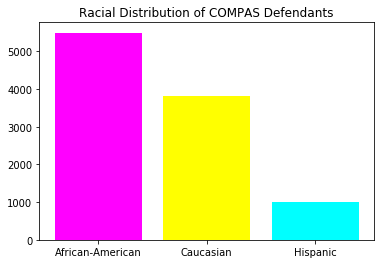

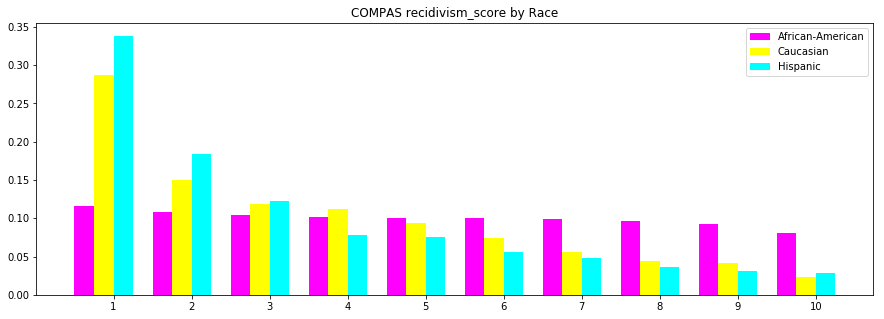

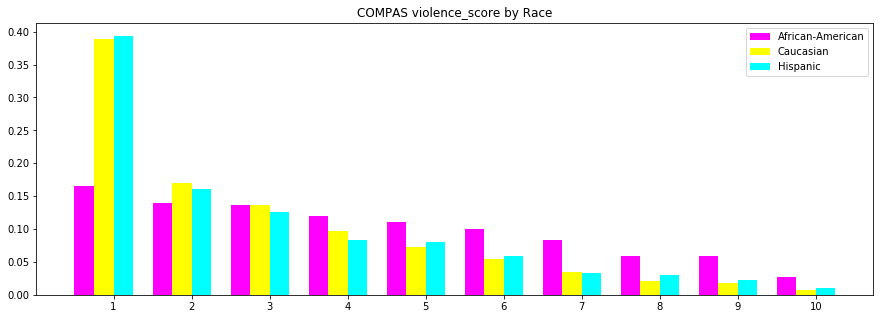

<Figure size 1080x360 with 0 Axes>

In [0]:
# YOUR CODE HERE:
plot_racial_distrib()
plot_feature_by_race('recidivism_score')
plot_feature_by_race('violence_score')
# END CODE

## Clean up the Data a Little More

Just like in week 3, we want to convert our data from a human-readable format to a format more amenable for a neural network. We need to convert text in our data into meaningful numbers. For instance, below we map "Male" to 0 and "Female" to 1. Note that for `race`, we want to use a one-hot encoding again, just as in week 3.

In [0]:
# Convert strings to numerical values.
sex_classes = {'Male': 0, 'Female' : 1}

processed_data = data.copy()
processed_data['sex'] = data['sex'].apply(lambda x: sex_classes[x])

# One-hot encode race.
processed_data = pd.get_dummies(processed_data, columns = ['race'])
columns = processed_data.columns.tolist()
columns = columns[0:3] + columns[9:] + columns[3:9]
processed_data = processed_data.reindex(columns = columns)

processed_data.head()

,name,sex,age,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,num_priors,charge,violence_score,recidivism_score,violence_true,recidivism_true
0,miguel hernandez,0,69,0,0,0,0,0,1,0,Aggravated Assault w/Firearm,1,1,0,0
2,kevon dixon,0,34,1,0,0,0,0,0,0,Felony Battery w/Prior Convict,1,3,1,1
3,ed philo,0,24,1,0,0,0,0,0,4,Possession of Cocaine,3,4,0,1
4,marcu brown,0,23,1,0,0,0,0,0,1,Possession of Cannabis,6,8,0,0
5,bouthy pierrelouis,0,43,0,0,0,0,0,1,2,arrest case no charge,1,1,0,0


In [0]:
# Convert Pandas dataframe to NumPy array for easier processing.
processed_data = processed_data.values

## Part 2: Partition into Train and Test Sets

We will focus on predicting recidivism scores from defendant data and recidivism ground truth. This is now a binary classification problem where our inputs are sex, age, race, and number of prior convictions. Our output is 1 (high risk of recidivism) or 0 (low risk of recidivism). The entire dataset has already been split into inputs (X) and outputs (y). 


In [0]:
# Split into input (X) and output (y) variables.
X = processed_data[:,1:10] # sex, age, race, num_priors
y = processed_data[:,14] # recidivism_true

num_train = int(math.ceil(X.shape[0]*0.8))

**Your task:** Partition the dataset into two sets: train (80%) and test (20%). The validation split will happen later automatically (using Keras). Assume the records have already been shuffled.

In [0]:
# YOUR CODE HERE:
X_train = X[:num_train]
y_train = y[:num_train]

X_test = X[num_train:]
y_test = y[num_train:]
# END CODE

num_classes = 2
# Convert output classes to one-hot encodings. As a result,
# we use softmax instead of sigmoid later.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(X_train.shape[0], 'records in train set')
print(X_test.shape[0], 'records in test set')
print(X.shape[0], 'records in total')

8822 records in train set
2205 records in test set
11027 records in total


## Part 3: Create a Baseline Model

**Your task:** At this point, we're ready to create a basic neural network classifier using Keras. Check this [guide](https://keras.io/getting-started/sequential-model-guide/) out to get started with Keras. Your model should have 4 Dense (fully-connected) layers, of sizes 50, 100, 50, and `num_classes`. All layers, save the last one, should use a ReLU activation function. The last layer should use softmax (why not sigmoid, since this is binary classification?). Make sure you pass in the *input_dim* parameter for the first layer, to tell Keras what size the input vectors are.

In [0]:
batch_size = 64
epochs = 25
learning_rate = 1e-5

#########################################################
# Initializes baseline neural network with 4 layers.
# ReLU and Softmax activations. Cross-entropy loss.
#########################################################
def baseline_classifier(learning_rate):
    # Create sequential model.
    model_baseline = Sequential()

    # YOUR CODE HERE:
    model_baseline.add(Dense(50, input_dim = X.shape[1], activation = 'relu')) 
    model_baseline.add(Dense(100, activation = 'relu')) 
    model_baseline.add(Dense(50, activation = 'relu')) 
    model_baseline.add(Dense(num_classes, activation = 'softmax'))
    # END CODE

    # Compile model.
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_baseline.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_baseline

model_baseline = baseline_classifier(learning_rate)

Instructions for updating:
Colocations handled automatically by placer.


## Part 4: Train and Evaluate the Baseline Model

**Your task:** Use the `eval()` function below to train and evaluate our baseline model. The return value of `eval()` is a tuple of loss and accuracy. Print both of these. In `eval()`, feel free to change the value of the `verbose` parameter. When `verbose = 0`, no information is printed. When it's 5, a lot of detailed information about the training process gets printed. Your test accuracy for this basic model should be around 69%.

Note that a parameter is `model.fit()` is `validation_split`. This takes a float from 0 to 1, representing the percentage of the training set to use for validation. Why do we need a validation set? More than training performance, we are interested in how our model does on unseen data. We can split data into only training and test. But if we then optimize our model using results from the test set, our test set can no longer be considered unseen data. As a workaround, we split our dataset into train, validation, and test. This way, we can optimize on our validation set, and only touch our test set at the very end.

In [0]:
#########################################################
# Trains and evaluates given model. Returns loss and 
# accuracy.
#########################################################
def eval(model, verb = 2):
    # Fit the model.
    model.fit(X_train, y_train, 
              epochs = epochs, 
              batch_size = batch_size,          
              validation_split = 0.1,
              verbose = verb,
              shuffle = False)
    
    # Evaluate the model.
    scores = model.evaluate(X_test, y_test)
    
    return scores

# YOUR CODE HERE:
loss, acc = eval(model_baseline)
print('\n\nTest loss:', loss)
print('Test accuracy:', acc)
# END CODE

Instructions for updating:
Use tf.cast instead.
Train on 7939 samples, validate on 883 samples
Epoch 1/25
 - 1s - loss: 1.2737 - acc: 0.3333 - val_loss: 0.9236 - val_acc: 0.2990
Epoch 2/25
 - 0s - loss: 0.7928 - acc: 0.3411 - val_loss: 0.7131 - val_acc: 0.4983
Epoch 3/25
 - 0s - loss: 0.6939 - acc: 0.6107 - val_loss: 0.6728 - val_acc: 0.6614
Epoch 4/25
 - 0s - loss: 0.6736 - acc: 0.6595 - val_loss: 0.6609 - val_acc: 0.6772
Epoch 5/25
 - 0s - loss: 0.6661 - acc: 0.6638 - val_loss: 0.6547 - val_acc: 0.6761
Epoch 6/25
 - 0s - loss: 0.6611 - acc: 0.6639 - val_loss: 0.6500 - val_acc: 0.6761
Epoch 7/25
 - 0s - loss: 0.6566 - acc: 0.6639 - val_loss: 0.6455 - val_acc: 0.6761
Epoch 8/25
 - 0s - loss: 0.6520 - acc: 0.6639 - val_loss: 0.6412 - val_acc: 0.6761
Epoch 9/25
 - 0s - loss: 0.6476 - acc: 0.6639 - val_loss: 0.6373 - val_acc: 0.6761
Epoch 10/25
 - 0s - loss: 0.6438 - acc: 0.6639 - val_loss: 0.6342 - val_acc: 0.6761
Epoch 11/25
 - 0s - loss: 0.6407 - acc: 0.6639 - val_loss: 0.6316 - val_ac

## Part 5: Introduce Regularization

Above, you might have noticed that your train accuracies were consistently higher than your test accuracy.  Another issue is that the train losses continue to decrease while the validation losses hit a minimum then increase. Both of these things are indicators of overfitting. Right now, our model doesn't generalize as well as we want. Regularization is a way to fix this. Regularization reduces overfitting by adding a penalty to the loss function. By adding this penalty, the model is trained such that it does not learn interdependent sets of features weights.

**Your task:** Add L2 regularization to each hidden layer of our model. You may want to refer to the [Keras documentation about regularizers](https://keras.io/regularizers/). You may see up to a 5% gain in test accuracy after adding in regularization.

In [0]:
reg_strength = 5e-4

#########################################################
# Initializes neural network with L2 regularization.
#########################################################
def regularized_classifier(learning_rate, reg_strength):
    # create model
    model_regularized = Sequential()

    # YOUR CODE HERE:
    model_regularized.add(Dense(50, input_dim = X.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(reg_strength))) 
    model_regularized.add(Dense(100, activation = 'relu', kernel_regularizer=regularizers.l2(reg_strength))) 
    model_regularized.add(Dense(50, activation = 'relu', kernel_regularizer=regularizers.l2(reg_strength))) 
    model_regularized.add(Dense(num_classes, activation = 'softmax'))
    # END CODE
    
    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_regularized.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_regularized

for reg_strength in [1e-1, 1e-2, 1e-3, 1e-4]:
  print()
  print("Regularization strength: %f" % reg_strength)
  model_regularized = regularized_classifier(learning_rate, reg_strength)

  loss, acc = eval(model_regularized, verb = 0)
  print('\n\nTest loss:', loss)
  print('Test accuracy:', acc)


Regularization strength: 0.100000
2205/2205 [==============================] - 0s 19us/step


Test loss: 15.467106279386144
Test accuracy: 0.6770975058311237

Regularization strength: 0.010000
2205/2205 [==============================] - 0s 18us/step


Test loss: 2.0944519358697664
Test accuracy: 0.6616780044540527

Regularization strength: 0.001000
2205/2205 [==============================] - 0s 20us/step


Test loss: 0.7897342773251522
Test accuracy: 0.6612244899581079

Regularization strength: 0.000100
2205/2205 [==============================] - 0s 20us/step


Test loss: 0.6047534788546919
Test accuracy: 0.6897959185295365


## How does this compare with COMPAS?

At this point, you've trained a model using defendant survey data and recidivism ground truth, and tried to improve your model with regularization. Still, you should see that from the first plot, African-Americans are predicted to be more likely to recidivate, compared to Caucasians and Hispanics after normalizing for population size. 

This tells us a few things. First, even with a sound machine learning pipeline, it's possible to get a biased model. Secondly, biased models are largely a result of biased data. If we look at the racial distribution of the COMPAS dataset again, we see that of recidivating defendants, African-Americans are the clear plurality. Our dataset just has more instances of recidivating African-Americans (see plot 2), which is either a result of biased selection by the creators of the dataset or racial disparities in policing in the US.

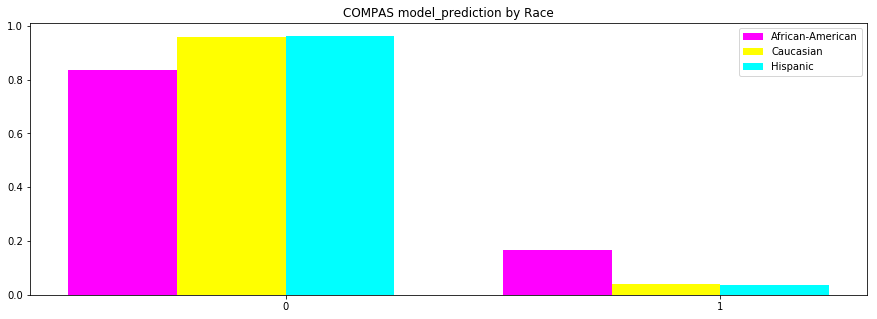

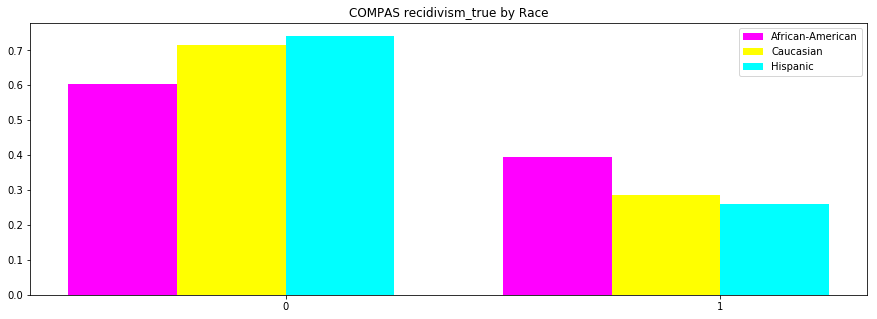

<Figure size 1080x360 with 0 Axes>

In [0]:
# Use model to make a prediction for every defendant.
y_model = model_regularized.predict_classes(X)
data['model_prediction'] = y_model

plot_feature_by_race('model_prediction')
plot_feature_by_race('recidivism_true')

## (Bonus) Part 6: Introduce Dropout

Dropout is another regularization technique to prevent over-fitting. Dropout randomly selects neurons to ignore during training. In other words, they are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. 

**Your task:** Remove the regularization, and this time around, add dropout for the input layer. You may want to refer to the [Keras documentation about the Dropout layer](https://keras.io/layers/core/). You may see up to a 5% increase in test accuracy compared to the regularization model.

In [0]:
dropout_strength = 1e-2

#########################################################
# Initializes neural network with dropout.
#########################################################
def dropout_classifier(learning_rate, dropout_strength):
    # create model
    model_dropout = Sequential()

    # YOUR CODE HERE:
    model_dropout.add(Dropout(dropout_strength, input_shape = (X.shape[1],)))
    model_dropout.add(Dense(50, activation = 'relu')) 
    model_dropout.add(Dense(100, activation = 'relu')) 
    model_dropout.add(Dense(50, activation = 'relu')) 
    model_dropout.add(Dense(num_classes, activation = 'softmax'))
    # END CODE
    
    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_dropout.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_dropout

model_dropout = dropout_classifier(learning_rate, dropout_strength)

loss, acc = eval(model_dropout, verb = 0)
print('\n\nTest loss:', loss)
print('Test accuracy:', acc)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2205/2205 [==============================] - 0s 20us/step


Test loss: 0.5895479114688172
Test accuracy: 0.6829931969004693


## (Bonus) Part 7: Introduce Batch Normalization

Batch Normalization is used to help remedy “covariate shifts”, or changes in the distribution of function’s domain.
They help keep activations in the zero-mean unit-variance range. You might use batch normalization for the same reasons that you normalized the entire dataset initially.

**Your task:** For our final exercise, keep dropout. Add batch normalization after the first dense layer. You may want to refer to the [Keras documentation about the BatchNorm layer](https://keras.io/layers/normalization/). You may see up to a 5% increase in test accuracy compared to the dropout-only model.

In [0]:
#########################################################
# Initializes neural network with dropout.
#########################################################
def batchnorm_classifier(learning_rate, dropout_strength):
    # create model
    model_batchnorm = Sequential()

    # YOUR CODE HERE:
    model_batchnorm.add(Dropout(dropout_strength, input_shape = (X.shape[1],)))
    model_batchnorm.add(Dense(50, activation = 'relu')) 
    model_batchnorm.add(BatchNormalization())
    model_batchnorm.add(Dense(100, activation = 'relu')) 
    model_batchnorm.add(Dense(50, activation = 'relu')) 
    model_batchnorm.add(Dense(num_classes, activation = 'softmax'))
    # END CODE
    
    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    model_batchnorm.compile(loss = keras.losses.categorical_crossentropy, 
                  optimizer = sgd, metrics=['accuracy'])
    
    return model_batchnorm

model_batchnorm = batchnorm_classifier(learning_rate, dropout_strength)

loss, acc = eval(model_batchnorm, verb = 0)
print('\n\nTest loss:', loss)
print('Test accuracy:', acc)

2205/2205 [==============================] - 0s 21us/step


Test loss: 0.7960371896523196
Test accuracy: 0.48344671189649846
